# ***ESPECIALIZACIÓN EN CIENCIA DE DATOS E INTELIGENCIA ARTIFICIAL***
### **Asignatura:**  Proyecto I

**Presentado por:** 
- Jonatan Andres Londoño Taborda
- John Freddy Ossa Patiño
- Felipe Londoño Mendoza

--------------------------------------------

# Contexto del Proyecto

El presente trabajo tiene como objetivo construir un modelo supervisado de clasificación que permita automatizar la decisión sobre el tratamiento de órdenes de desviaciones significativas en consumos de los servicios de energía, acueducto, alcantarillado y gas que presta Empresas Públicas de Medellín (EPM) a sus clientes, generadas cuando se detectan consumos que se salen de unos rangos establecidos por ley en un periodo determinado.

Actualmente, estas órdenes son revisadas manualmente por un equipo de analistas que determina si deben legalizar o enviarse una revisión a terreno para tener mas argumentos. El desarrollo de este modelo busca replicar ese proceso humano a partir de datos históricos, con el fin de reducir visitas innecesarias y optimizar los costos operativos asociados.

---

## Proceso de Análisis

Para lograr este objetivo, se ejecutará el siguiente flujo de trabajo:

1. **Análisis Exploratorio de Datos (EDA)**
2. **Depuración y preparación de los datos**
3. **Entrenamiento y comparación de modelos de clasificación**:
   - Random Forest
   - XGBoost Lineal
4. **Conclusiones**

---

## Evaluación y Métricas

- Se evaluará el desempeño de cada modelo utilizando la métrica F1 Score, ideal para escenarios con datos desbalanceados, ya que equilibra la precisión.
- La división de los datos será del 80% para entrenamiento y 20% para prueba.

Además, el modelo generará una probabilidad de legalización para cada orden. Si esta probabilidad supera el 80%, se considerará que la orden puede ser legalizada automáticamente, sin la intervención de un analista.

---


## Descripción de los Datos

Para el entrenamiento del modelo supervisado de clasificación se cuenta con un conjunto de datos históricos que contiene información sobre órdenes de desviación significativa generadas por incrementos en el consumo de servicios públicos. Estas órdenes fueron previamente revisadas por analistas, quienes tomaron decisiones basadas en las condiciones observadas.

### Variable Objetivo: `RESPUESTA`

La variable `RESPUESTA` representa la decisión final tomada por el analista, y se comporta de la siguiente manera:

| Caso | ¿Modifica Consumo? | ¿Envía a terreno? | RESPUESTA |
|------|--------------------|-------------------|-----------|
| 1    | Sí                 | No                | 1         |
| 2    | Sí                 | Sí                | 1         |
| 3    | No                 | Sí                | 1         |
| 4    | No                 | No                | 0         |

#### Interpretación de los casos:
- **Caso 1:** El analista detecta un error claro en el consumo y lo ajusta sin necesidad de verificación en terreno.
- **Caso 2:** El analista ajusta parcialmente el consumo, pero requiere una visita en terreno para validar la parte restante antes de decidir su facturación definitiva.
- **Caso 3:** El analista no ajusta el consumo por falta de evidencia suficiente, pero mantiene dudas que requieren una inspección en terreno.
- **Caso 4:** El consumo investigado es considerado válido y no necesita ajustes ni verificación en terreno.

Por tanto, la clase `1` agrupa todas las situaciones en las que se toma alguna acción correctiva o preventiva adicional, mientras que la clase `0` representa los casos cerrados sin intervención alguna.

---

### Variables Predictoras

Las demás columnas del dataset representan condiciones observadas por el analista en el momento de tomar la decisión, y serán utilizadas como **variables predictoras** en el modelo. Estas incluyen, entre otras:

|Contador| Variable         | Definición                                                                       | Valores                                                                                |
|--------|------------------|----------------------------------------------------------------------------------|----------------------------------------------------------------------------------------|
|1       | RESPUESTA        | decisión final tomada por el analista.                                           |1 = Se tomó acción, 0 = No se tomó ninguna acción                                       |
|2       | CONSUMO_CRITICADO| Valor del consumo que se encuentra en investigación.                             |                                                                                        |
|3       | SERVICIO         | Tipo de servicio involucrado (agua, energía, etc.).                              |                                                                                        |
|4       | CATEGORIA        | Segmento del usuario (residencial, industrial, etc.).                            |                                                                                        |
|5       | NIVEL_TENSION    | Indica el nivel de voltaje al que se suministra el servicio de energía eléctrica.|                                                                                        |
|6       | ESTRATO          | Estrato socio economico del predio.                                              |1 = Estrato 1, 2 = Estrato 2, 3 = Estrato 3, 4 = Estrato 4, 5 = Estrato 5, 6 = Estrato 6|
|7       | LOCALIDAD        | Municipio donde se se presta el servicio.                                        |                                                                                        |
|8       | FUNCION_ANALISIS | Algoritmo o lógica aplicada para el análisis del consumo.                        |                                                                                        |
|9       | CALIFICACION     | Clasificación del nivel de desviación identificado.                              |                                                                                        |
|10      | OBS_LECTURA      | Observaciones sobre la lectura del medidor que realiza el lector.                |                                                                                        |
|11      | PERIODICIDAD     | Frecuencia o periodicidad con la que se factura el servicio.                     | 1 = Mensual, 2 = Bimestral, 3 = Trimestral                                             |


**Cantidad de observaciones**: 85.812

Estas variables permitirán al modelo aprender de los patrones y comportamientos históricos, con el objetivo de replicar las decisiones de los analistas en nuevos casos.

---


# *1.Carga de datos y análisis exploratorio de los datos (EDA)*

In [276]:
#Importación de la librerías que se usarán
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [243]:
mapeo_columnas = {
    'RESPUESTA': 'respuesta', 
    'CONSUMO_CRITICADO': 'consumo_criticado', 
    'SERVICIO': 'servicio',
    'CATEGORIA': 'categoria', 
    'NIVEL_TENSION': 'nivel_tension', 
    'ESTRATO': 'estrato', 
    'LOCALIDAD': 'localidad', 
    'FUNCION_ANALISIS': 'funcion_analisis',
    'CALIFICACION': 'calificacion',
    'OBS_LECTURA': 'obs_lectura',
    'PERIODICIDAD': 'periodicidad'
}

In [244]:
# Cargar el set de datos
archivo = "BD_ordenes.xlsx"
df = pd.read_excel(archivo)

df = df.rename(columns=mapeo_columnas)

df.head()

,respuesta,consumo_criticado,servicio,categoria,nivel_tension,estrato,localidad,funcion_analisis,calificacion,obs_lectura,periodicidad
0,1,0.0,701-ENERGÍA MDO REGULADO,3-INDUSTRIAL,220.0,NaN,5088-BELLO,CALCCOPR - Calcular Consumo Penalizado de Ener...,5035-BAJO ENERGIA (<-50%),30-VARIACION NIVEL DE UTILIZACIÓN,1
1,1,420.0,701-ENERGÍA MDO REGULADO,3-INDUSTRIAL,220.0,NaN,5088-BELLO,CALCCOPR - Calcular Consumo Penalizado de Ener...,5080-MUY ALTO (>500%),30-VARIACION NIVEL DE UTILIZACIÓN,1
2,1,99999.0,101-AGUA POTABLE,1-RESIDENCIAL,NaN,1.0,5088-BELLO,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%),34-LECTURA MENOR,1
3,1,881.0,701-ENERGÍA MDO REGULADO,3-INDUSTRIAL,220.0,NaN,5088-BELLO,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%),35-NO HAY JUSTIFICACION,1
4,1,99999.0,701-ENERGÍA MDO REGULADO,1-RESIDENCIAL,220.0,4.0,5001-MEDELLÍN,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%),34-LECTURA MENOR,1


In [245]:
#Cantidad de órdenes por respuesta del analista
(df['respuesta'].value_counts(normalize=True) * 100).round(2).astype(str) + ' %'

respuesta
1    65.98 %
0    34.02 %
Name: proportion, dtype: object

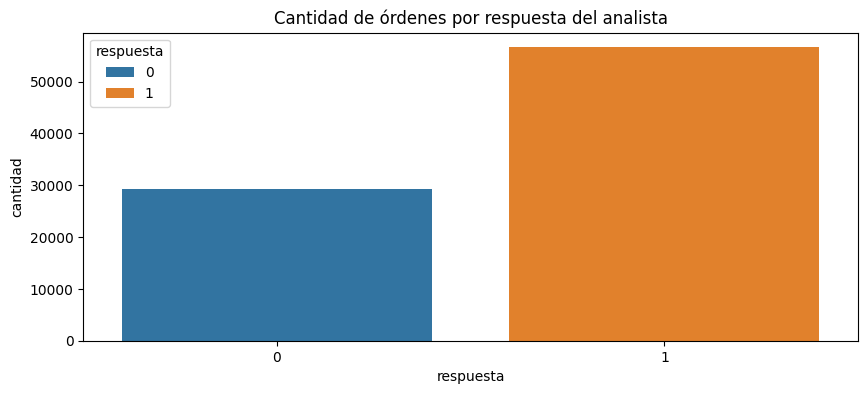

In [246]:
plt.figure(figsize=(10, 4))
sns.countplot(x='respuesta', hue='respuesta', data=df)
plt.ylabel('cantidad')
plt.title('Cantidad de órdenes por respuesta del analista');


El gráfico anterior muestra la cantidad de órdenes clasificadas por los analistas según la variable respuesta, la cual indica si se tomó alguna acción (1) o no (0).

Existe un desbalance moderado en las respuestas:

respueta (1): 65.98%

respueta (0): 34.02%

Aunque respuesta = 1 es claramente dominante, la clase 0 todavía representa una proporción considerable del total.

---

---

In [247]:
# Agrupar por SERVICIO y obtener conteo de RESPUESTA
tabla_resumen = df.groupby('servicio')['respuesta'].value_counts().unstack(fill_value=0)

# Agregar columna con total por servicio
tabla_resumen['TOTAL'] = tabla_resumen.sum(axis=1)

# Ordenar de forma descendente
tabla_resumen_ordenada = tabla_resumen.sort_values(by='TOTAL', ascending=False)

# Mostrar resultado
tabla_resumen_ordenada


respuesta,0,1,TOTAL
servicio,,,
101-AGUA POTABLE,12916,24899,37815
701-ENERGÍA MDO REGULADO,7013,17540,24553
501-GAS NATURAL REGULADO,2403,4591,6994
249-AGUA POTABLE DE RIONEGRO ANT,4025,1908,5933
8003-AGUA POTABLE URABA,1285,2936,4221
240-AGUA POTABLE MALAMBO,397,2320,2717
7505-GAS NATURAL COMPRIMIDO (GNC),462,1392,1854
8000-AGUA POTABLE OCC.,659,963,1622
103-ALCANTARILLADO,4,58,62


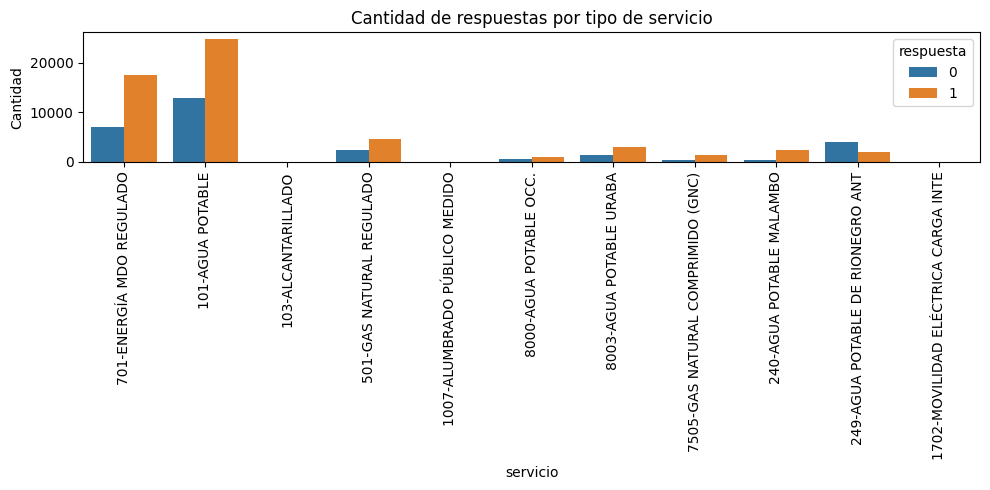

In [248]:
plt.figure(figsize=(10, 5))
sns.countplot(x='servicio', hue='respuesta', data=df)
plt.title("Cantidad de respuestas por tipo de servicio")
plt.xlabel("servicio")
plt.ylabel("Cantidad")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

La tabla y el gráfico anterior muestran la distribución de respuestas (respuesta = 0 o 1) por tipo de servicio. Se destacan los siguientes puntos:

1. 101-AGUA POTABLE es el servicio con mayor cantidad de órdenes registradas, acumulando más de 37.800 casos, de los cuales ~66% tuvieron una acción del analista (respuesta = 1)
2. 701-ENERGÍA MDO REGULADO le sigue en volumen, con más de 24.500 registros, también con una alta proporción de respuestas afirmativas. 
3. 501-GAS NATURAL REGULADO y 249-AGUA POTABLE DE RIONEGRO ANT tienen menor participación, pero aún representan volúmenes importantes.

En todos los servicios, la clase respuesta = 1 predomina, lo que sugiere que la mayoría de las órdenes implicaron una acción por parte del analista (modificación del consumo y/o solicitud de visita en terreno). No obstante, hay diferencias entre servicios. Por ejemplo, en "249-AGUA POTABLE DE RIONEGRO ANT", el número de respuestas 0 supera al de respuestas 1, lo cual es una señal de comportamiento distinto respecto a los demás servicios.

---

---

In [249]:
# Agrupar por SERVICIO y obtener conteo de RESPUESTA
tabla_resumen = df.groupby('localidad')['respuesta'].value_counts().unstack(fill_value=0)

# Agregar columna con total por servicio
tabla_resumen['TOTAL'] = tabla_resumen.sum(axis=1)

# Ordenar de forma descendente
tabla_resumen_ordenada = tabla_resumen.sort_values(by='TOTAL', ascending=False)

# Mostrar resultado
tabla_resumen_ordenada

respuesta,0,1,TOTAL
localidad,,,
5001-MEDELLÍN,9175,19580,28755
5266-ENVIGADO,5425,10060,15485
5615-RIONEGRO,4611,3292,7903
5045-APARTADÓ,1569,5584,7153
5088-BELLO,2212,4157,6369
...,...,...,...
5125-CAICEDO,0,1,1
5660-SAN LUIS,0,1,1
5674-SAN VICENTE FERRER,0,1,1


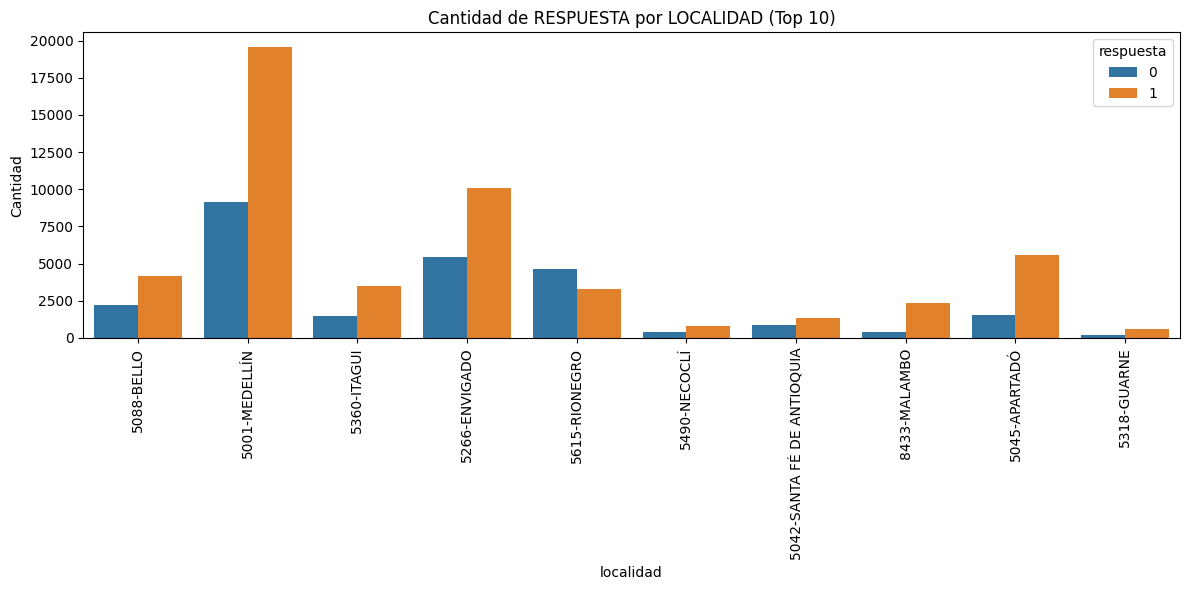

In [250]:
plt.figure(figsize=(12, 6))
top_localidades = df['localidad'].value_counts().nlargest(10).index
#top_localidades = df['localidad'].value_counts().index
df_localidad_top = df[df['localidad'].isin(top_localidades)]
sns.countplot(x='localidad', hue='respuesta', data=df_localidad_top)
plt.title("Cantidad de RESPUESTA por LOCALIDAD (Top 10)")
plt.xlabel("localidad")
plt.ylabel("Cantidad")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

El gráfico y la tabla muestran la distribución de la variable respuesta por localidad, permitiendo identificar patrones de decisión según la zona geográfica.

1. 5001-MEDELLÍN concentra la mayor cantidad de órdenes (28.755), con una fuerte predominancia de acciones (respuesta = 1 en ~68% de los casos).
2. 5266-ENVIGADO y 5615-RIONEGRO también presentan volúmenes altos, aunque en Rionegro el número de respuestas 0 es relativamente elevado comparado con otras zonas.

La mayoría de las localidades presentan una tendencia consistente: en más del 60% de los casos, los analistas decidieron intervenir o solicitar revisión. Sin embargo, hay variaciones notables entre localidades como Rionegro, donde hay más decisiones de no intervenir (respuesta = 0), lo que podría deberse a mejores registros de lectura o menor complejidad en los casos.

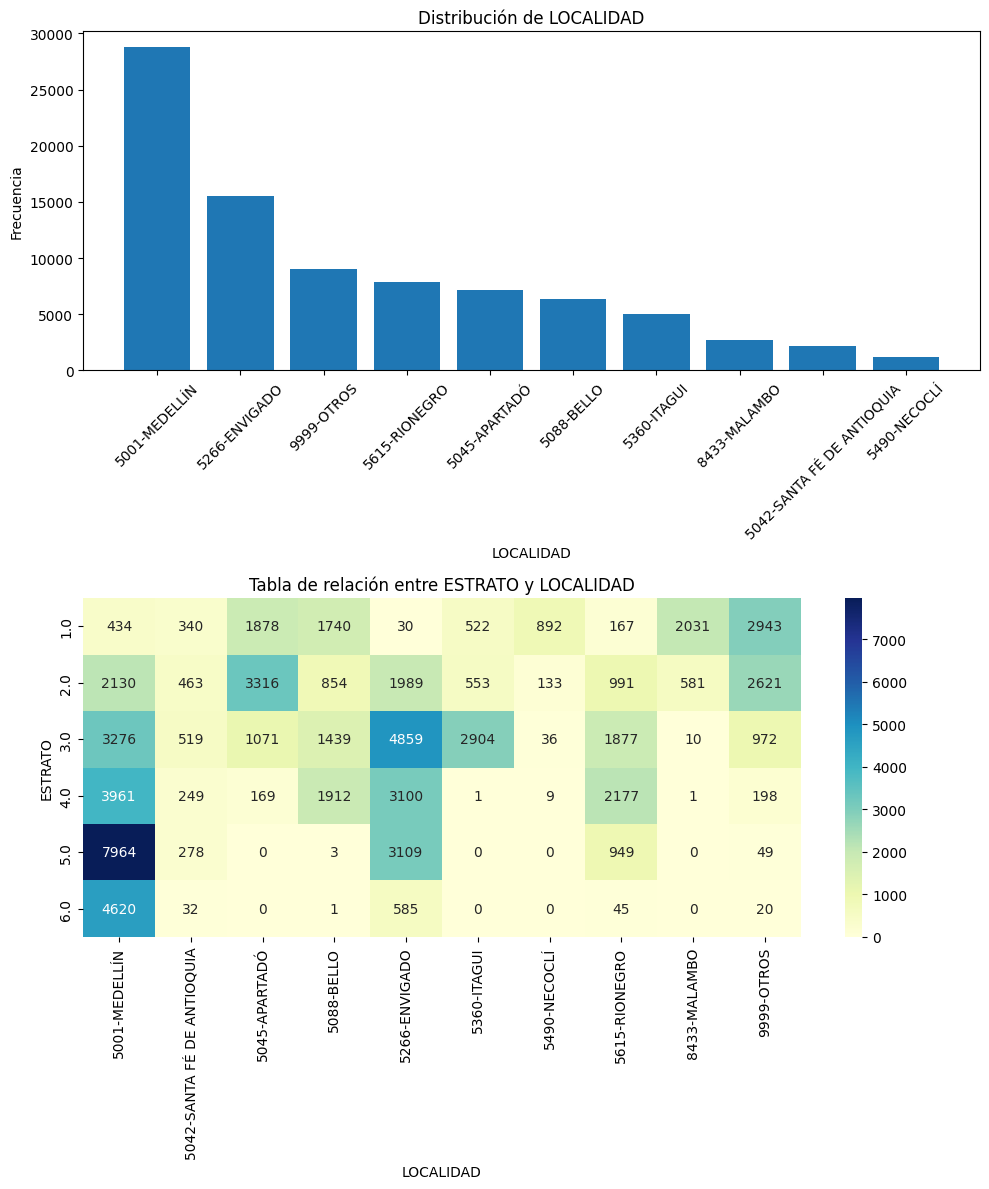

Análisis de la variable LOCALIDAD:
participacion_localidad
5001-MEDELLÍN                 28755
5266-ENVIGADO                 15485
9999-OTROS                     8986
5615-RIONEGRO                  7903
5045-APARTADÓ                  7153
5088-BELLO                     6369
5360-ITAGUI                    5039
8433-MALAMBO                   2717
5042-SANTA FÉ DE ANTIOQUIA     2201
5490-NECOCLÍ                   1203
Name: count, dtype: int64

Tabla de relación entre ESTRATO y LOCALIDAD:
participacion_localidad  5001-MEDELLÍN  5042-SANTA FÉ DE ANTIOQUIA  \
estrato                                                              
1.0                                434                         340   
2.0                               2130                         463   
3.0                               3276                         519   
4.0                               3961                         249   
5.0                               7964                         278   
6.0                

In [251]:
# Calcular la participación de cada localidad
locality_counts = df['localidad'].value_counts()
total_records = len(df)
locality_participation = locality_counts / total_records

# Crear una nueva variable PARTICIPACION_LOCALIDAD
df['participacion_localidad'] = df['localidad'].apply(lambda x: x if locality_participation[x] >= 0.01 else '9999-OTROS')

# Analizar la variable 'LOCALIDAD'
localidad_counts = df['participacion_localidad'].value_counts()

# Relacion entre ESTRATO y LOCALIDAD
contingency_table_dos = pd.crosstab(df['estrato'], df['participacion_localidad'])

# Chi cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table_dos)

# Grafico de resultados
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))


#LOCALIDAD
axes[0].bar(localidad_counts.index.astype(str), localidad_counts.values)
axes[0].set_title('Distribución de LOCALIDAD')
axes[0].set_xlabel('LOCALIDAD')
axes[0].set_ylabel('Frecuencia')
axes[0].tick_params(axis='x', rotation=45)

#tabla de relacion
sns.heatmap(contingency_table_dos, annot=True, fmt='d', cmap='YlGnBu', ax=axes[1])
axes[1].set_title('Tabla de relación entre ESTRATO y LOCALIDAD')
axes[1].set_xlabel('LOCALIDAD')
axes[1].set_ylabel('ESTRATO')

plt.tight_layout()
plt.show()

print("Análisis de la variable LOCALIDAD:")
print(localidad_counts)
print("\nTabla de relación entre ESTRATO y LOCALIDAD:")
print(contingency_table_dos)
print("\nResultados del test Chi-cuadrado:")
print(f"Chi-cuadrado: {chi2}")
print(f"P-valor: {p}")
print(f"Grados de libertad: {dof}")


Conclusiones:

Medellín tiene la mayor participación en el conjunto de datos con 28,755 registros, lo que representa una parte significativa del total. Esto sugiere que Medellín es una de las localidades con mayor anomalía de servicios.
Envigado sigue a Medellín con 15,485 registros, indicando también una alta demanda en la muestra.
Otras Localidades: Las localidades con menos del 1% de participación se agrupan bajo "OTROS", lo que incluye varias localidades con menor representación en el conjunto de datos.

La tabla de relación muestra cómo se distribuyen los diferentes estratos en las distintas localidades. Por ejemplo, en Medellín, la mayoría de los registros provienen de Estrato 3, seguido por Estrato 2.
En localidades como Envigado y Rionegro, también se observa una alta representación de Estrato 3 y Estrato 2.

In [252]:
# Agrupar por SERVICIO y obtener conteo de RESPUESTA
tabla_resumen = df.groupby('categoria')['respuesta'].value_counts().unstack(fill_value=0)

# Agregar columna con total por servicio
tabla_resumen['TOTAL'] = tabla_resumen.sum(axis=1)

# Ordenar de forma descendente
tabla_resumen_ordenada = tabla_resumen.sort_values(by='TOTAL', ascending=False)

# Mostrar resultado
tabla_resumen_ordenada

respuesta,0,1,TOTAL
categoria,,,
1-RESIDENCIAL,25063,45940,71003
2-COMERCIAL,2403,6483,8886
3-INDUSTRIAL,1035,3443,4478
4-OFICIAL,455,578,1033
11-CONSUMOS EPMTELCO,138,43,181
5-ESPECIAL,36,73,109
7-AUTOCONSUMOS EPM,47,31,78
5-EXENTA,15,24,39
14-ENERGIA BOMBEO ACUEDUCTO,1,3,4


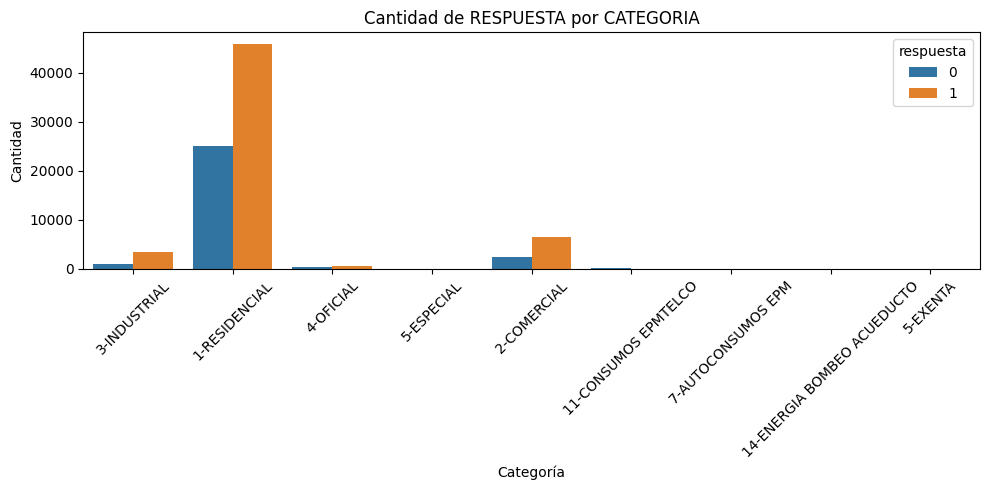

In [253]:
plt.figure(figsize=(10, 5))
sns.countplot(x='categoria', hue='respuesta', data=df)
plt.title("Cantidad de RESPUESTA por CATEGORIA")
plt.xlabel("Categoría")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La variable categoria agrupa a los usuarios según su tipo de consumo (residencial, comercial, industrial, etc.). El análisis muestra cómo se distribuyen las respuestas de los analistas en cada una de estas categorías.

1. 1-RESIDENCIAL domina claramente el conjunto de datos con más de 71.000 órdenes (~80% del total). Le siguen 2-COMERCIAL y 3-INDUSTRIAL, aunque con volúmenes considerablemente menores (8.800 y 4.400 registros, respectivamente).

2. En todas las categorías, predomina la respuesta 1, es decir, que en la mayoría de los casos los analistas decidieron intervenir o solicitar revisión.
3. La categoría residencial tiene una proporción de respuesta = 1 cercana al 65%.

---

---

In [254]:
# Agrupar por estrato y respuesta
tabla_estrato = df.groupby('estrato')['respuesta'].value_counts().unstack(fill_value=0)
tabla_estrato['TOTAL'] = tabla_estrato.sum(axis=1)
tabla_estrato_ordenada = tabla_estrato.sort_values(by='estrato')
tabla_estrato_ordenada

respuesta,0,1,TOTAL
estrato,,,
1.0,3059,7918,10977
2.0,4004,9627,13631
3.0,5935,11028,16963
4.0,4890,6887,11777
5.0,5182,7170,12352
6.0,1993,3310,5303


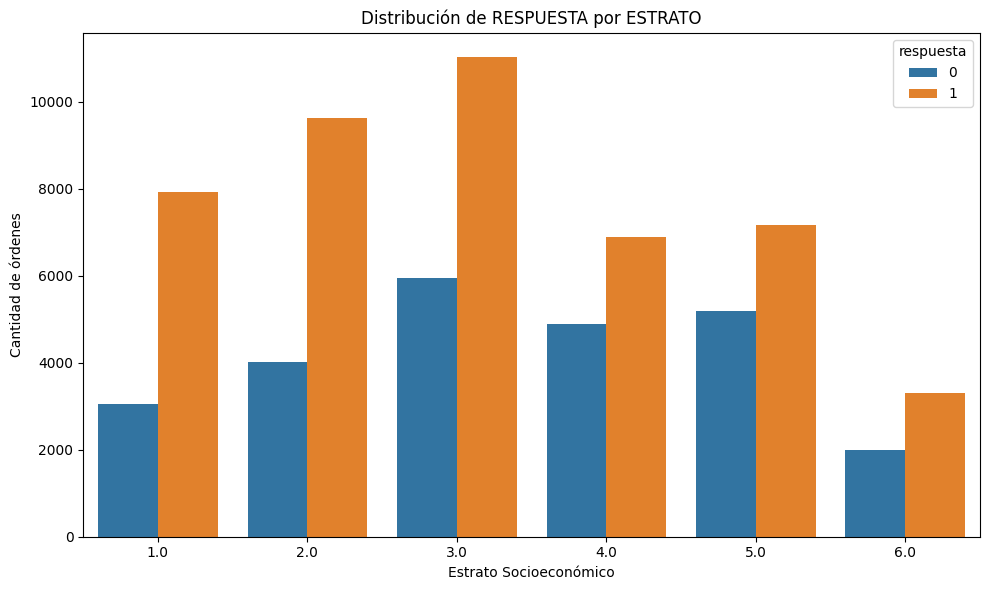

In [255]:
plt.figure(figsize=(10, 6))
sns.countplot(x='estrato', hue='respuesta', data=df)
plt.title("Distribución de RESPUESTA por ESTRATO")
plt.xlabel("Estrato Socioeconómico")
plt.ylabel("Cantidad de órdenes")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

1. Los estratos 2 y 3 concentran la mayor cantidad de órdenes.
2. En todos los estratos, predomina la clase respuesta = 1, es decir, la mayoría de las órdenes requirieron una acción del analista (modificación o revisión).
3. El estrato 0, que corresponde a registros sin estrato definido, también presenta una proporción significativa de respuestas afirmativas.

No se observan diferencias radicales entre estratos en cuanto al patrón de decisión, pero sí se evidencia que los estratos bajos ( 1, 2) tienden a tener una mayor proporción relativa de intervención (respuesta = 1). Esto podría indicar que en contextos de menor capacidad socioeconómica se presentan más casos que generan dudas en el consumo o mayor sensibilidad ante desviaciones.

Por otro lado, en estratos altos (como el 4), aunque hay menos volumen total, la tendencia se mantiene con un 58%–60% de intervenciones.

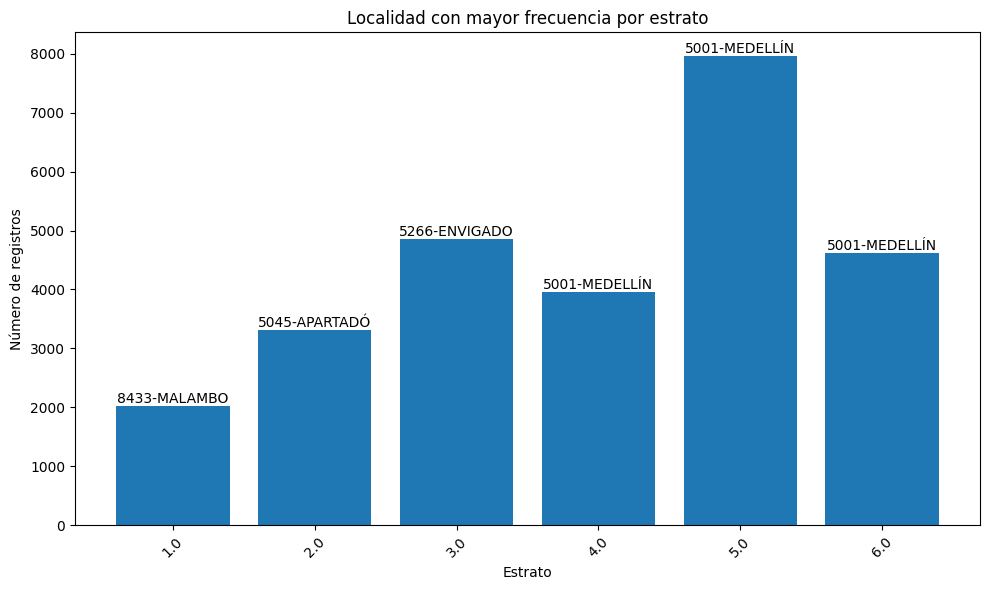

Localidad con mayor frecuencia por estrato:
estrato
1.0     8433-MALAMBO
2.0    5045-APARTADÓ
3.0    5266-ENVIGADO
4.0    5001-MEDELLÍN
5.0    5001-MEDELLÍN
6.0    5001-MEDELLÍN
Name: localidad, dtype: object


In [256]:
# Agrupar por 'ESTRATO' y encontrar la localidad con más registros para cada estrato
mas_comun_servicio_por_localidad = df.groupby('estrato')['localidad'].agg(lambda x: x.value_counts().idxmax())
servicio_counts_por_localidad = df.groupby(['estrato', 'localidad']).size().unstack().max(axis=1)

# Graficar los resultados
plt.figure(figsize=(10, 6))
bars = plt.bar(servicio_counts_por_localidad.index.astype(str), servicio_counts_por_localidad.values)

# Añadir etiquetas a las barras
for bar, label in zip(bars, mas_comun_servicio_por_localidad):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), label, ha='center', va='bottom')

plt.title('Localidad con mayor frecuencia por estrato')
plt.xlabel('Estrato')
plt.ylabel('Número de registros')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Imprimir los resultados
print("Localidad con mayor frecuencia por estrato:")
print(mas_comun_servicio_por_localidad)

Conclusiones:

-Estrato 1: La localidad con mayor frecuencia es 8433-MALAMBO. Esto indica que la mayoría de los registros en este estrato provienen de Malambo, lo que puede reflejar una alta desviacion de servicios en esta localidad.

-Estrato 2: 5045-APARTADÓ es la localidad más común en este estrato, sugiriendo que Apartadó tiene una representación significativa en el conjunto de datos.

-Estrato 3: La localidad con mayor frecuencia es 5266-ENVIGADO, lo que indica que Envigado es una de las localidades más importantes para este estrato.

-Estrato 4, 5 y 6: 5001-MEDELLÍN es la localidad más común, reflejando la importancia de Medellín en este estrato.

# *2.Depuración y preparación de los datos*

In [257]:
#Rellenar los nulos correspondientes a la variable "estrato" con cero.
df['estrato'] = df['estrato'].fillna(0)
df['nivel_tension'] = df['nivel_tension'].fillna(0)

In [258]:
#Cantidad de observaciones por nivel de tensión

tabla_nivel_tension = df['nivel_tension'].value_counts(dropna=False).reset_index()
tabla_nivel_tension.columns = ['nivel_tension', 'cantidad_observaciones']
total_observaciones = tabla_nivel_tension['cantidad_observaciones'].sum()
tabla_nivel_tension['porcentaje'] = (tabla_nivel_tension['cantidad_observaciones'] / total_observaciones * 100).round(2).astype(str) + ' %'
tabla_nivel_tension

,nivel_tension,cantidad_observaciones,porcentaje
0,0.0,61218,71.34 %
1,220.0,23627,27.53 %
2,13200.0,928,1.08 %
3,44000.0,38,0.04 %


### Nivel de tensión
1. Esta variable solo aplica para el servicio de energía (ej. 701-ENERGÍA MDO REGULADO), por lo que en otros servicios como agua, gas o alcantarillado, su valor es nulo o irrelevante.
2. En el caso del servicio de energía, existe una alta correlación entre nivel_tension y categoria. Por ejemplo:
 * Residencial: baja tensión
 * Industrial: media o alta tensión
 * Oficial o comercial: tensión media

### Conclusiones
Dado que nivel_tension solo es aplicable a un subconjunto de datos (energía), presenta alta correlación con la variable categoria y tiene variabilidad limitada y muchos valores nulos, se recomienda excluir esta variable del entrenamiento del modelo para evitar introducir ruido o redundancia

In [259]:
#Eliminar columna nivel de tensión
df.drop(columns=['nivel_tension'], inplace=True)

In [260]:
# dejar las categorías residencial, comercial e industrial y las demás categorías agruparlas
categorias_relevantes = [
    '1-RESIDENCIAL',
    '2-COMERCIAL',
    '3-INDUSTRIAL'
]

# Aplicar la transformación
df['categoria'] = df['categoria'].apply(
    lambda x: x if x in categorias_relevantes else '99-OTRAS CATEGORIAS'
)

df['categoria'].value_counts()

categoria
1-RESIDENCIAL          71003
2-COMERCIAL             8886
3-INDUSTRIAL            4478
99-OTRAS CATEGORIAS     1444
Name: count, dtype: int64

## *Feature Engineering*

In [261]:
# Diccionario de mapeo de servicio a tipo de servicio
mapeo_tipo_servicio = {
    '701-ENERGÍA MDO REGULADO': 'Energia',
    '101-AGUA POTABLE': 'Agua',
    '103-ALCANTARILLADO': 'Alcantarillado',
    '501-GAS NATURAL REGULADO': 'Gas',
    '1007-ALUMBRADO PÚBLICO MEDIDO': 'Energia',
    '8000-AGUA POTABLE OCC.': 'Agua',
    '8003-AGUA POTABLE URABA': 'Agua',
    '7505-GAS NATURAL COMPRIMIDO (GNC)': 'Gas',
    '240-AGUA POTABLE MALAMBO': 'Agua',
    '249-AGUA POTABLE DE RIONEGRO ANT': 'Agua',
    '1702-MOVILIDAD ELÉCTRICA CARGA INTE': 'Energia'
}

In [262]:
# Crear nueva columna 'tipo_servicio'
df['tipo_servicio'] = df['servicio'].map(mapeo_tipo_servicio)
df.drop(columns=['servicio'], inplace=True)
df.head()

,respuesta,consumo_criticado,categoria,estrato,localidad,funcion_analisis,calificacion,obs_lectura,periodicidad,participacion_localidad,tipo_servicio
0,1,0.0,3-INDUSTRIAL,0.0,5088-BELLO,CALCCOPR - Calcular Consumo Penalizado de Ener...,5035-BAJO ENERGIA (<-50%),30-VARIACION NIVEL DE UTILIZACIÓN,1,5088-BELLO,Energia
1,1,420.0,3-INDUSTRIAL,0.0,5088-BELLO,CALCCOPR - Calcular Consumo Penalizado de Ener...,5080-MUY ALTO (>500%),30-VARIACION NIVEL DE UTILIZACIÓN,1,5088-BELLO,Energia
2,1,99999.0,1-RESIDENCIAL,1.0,5088-BELLO,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%),34-LECTURA MENOR,1,5088-BELLO,Agua
3,1,881.0,3-INDUSTRIAL,0.0,5088-BELLO,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%),35-NO HAY JUSTIFICACION,1,5088-BELLO,Energia
4,1,99999.0,1-RESIDENCIAL,4.0,5001-MEDELLÍN,CALCCOLE - Calcular Consumo por Lecturas,5080-MUY ALTO (>500%),34-LECTURA MENOR,1,5001-MEDELLÍN,Energia


## *Proceso de label encoding*

In [263]:
df_modelo = df.copy()

In [264]:
df_modelo['codigo_observacion'] = df_modelo['obs_lectura'].str.split('-', n=1).str[0]
df_modelo['codigo_observacion'] = df_modelo['codigo_observacion'].astype(int)
df_modelo.drop(columns=['obs_lectura'], inplace=True)

df_modelo['codigo_calificacion'] = df_modelo['calificacion'].str.split('-', n=1).str[0]
df_modelo['codigo_calificacion'] = df_modelo['codigo_calificacion'].astype(int)
df_modelo.drop(columns=['calificacion'], inplace=True)

df_modelo['codigo_localidad'] = df_modelo['participacion_localidad'].str.split('-', n=1).str[0]
df_modelo['codigo_localidad'] = df_modelo['codigo_localidad'].astype(int)
df_modelo.drop(columns=['participacion_localidad'], inplace=True)
df_modelo.drop(columns=['localidad'], inplace=True)

df_modelo['codigo_categoria'] = df_modelo['categoria'].str.split('-', n=1).str[0]
df_modelo['codigo_categoria'] = df_modelo['codigo_categoria'].astype(int)
df_modelo.drop(columns=['categoria'], inplace=True)

In [265]:

# Columnas categóricas a codificar
columnas_categoricas = ['funcion_analisis','tipo_servicio']

# Inicializar codificadores
encoders = {}
for col in columnas_categoricas:
    le = LabelEncoder()
    df_modelo[col] = le.fit_transform(df_modelo[col].astype(str))
    encoders[col] = le  # Guardamos el encoder para posibles decodificaciones posteriores

# Verificar resultado
df_modelo.head()

,respuesta,consumo_criticado,estrato,funcion_analisis,periodicidad,tipo_servicio,codigo_observacion,codigo_calificacion,codigo_localidad,codigo_categoria
0,1,0.0,0.0,3,1,2,30,5035,5088,3
1,1,420.0,0.0,3,1,2,30,5080,5088,3
2,1,99999.0,1.0,2,1,0,34,5080,5088,1
3,1,881.0,0.0,2,1,2,35,5080,5088,3
4,1,99999.0,4.0,2,1,2,34,5080,5001,1


In [266]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85811 entries, 0 to 85810
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   respuesta            85811 non-null  int64  
 1   consumo_criticado    85811 non-null  float64
 2   estrato              85811 non-null  float64
 3   funcion_analisis     85811 non-null  int64  
 4   periodicidad         85811 non-null  int64  
 5   tipo_servicio        85811 non-null  int64  
 6   codigo_observacion   85811 non-null  int64  
 7   codigo_calificacion  85811 non-null  int64  
 8   codigo_localidad     85811 non-null  int64  
 9   codigo_categoria     85811 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 6.5 MB


In [267]:
df_modelo.describe()

,respuesta,consumo_criticado,estrato,funcion_analisis,periodicidad,tipo_servicio,codigo_observacion,codigo_calificacion,codigo_localidad,codigo_categoria
count,85811.000000,8.581100e+04,85811.000000,85811.000000,85811.000000,85811.000000,85811.000000,85811.000000,85811.000000,85811.000000
mean,0.659799,4.264194e+07,2.678141,4.412313,1.102073,0.883243,26.833227,3621.587570,5776.530911,2.857035
std,0.473779,4.818349e+09,1.840998,2.827490,0.427672,1.137977,12.936952,2260.864589,1564.119777,12.588828
min,0.000000,-1.600808e+06,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,5001.000000,1.000000
25%,0.000000,0.000000e+00,1.000000,2.000000,1.000000,0.000000,30.000000,220.000000,5001.000000,1.000000
50%,1.000000,1.250000e+01,3.000000,3.000000,1.000000,0.000000,31.000000,5036.000000,5088.000000,1.000000
75%,1.000000,1.550000e+02,4.000000,6.000000,1.000000,2.000000,35.000000,5080.000000,5360.000000,1.000000
max,1.000000,7.333327e+11,6.000000,13.000000,3.000000,3.000000,100.000000,5085.000000,9999.000000,99.000000


In [268]:
# Paso 1: 70% entrenamiento, 30% temporal
df_train, df_temp = train_test_split(
    df_modelo,
    test_size=0.30,
    stratify=df['respuesta'],
    random_state=42
)

In [269]:
# Paso 2: del 30% temporal, 15% test y 15% validación
df_test, df_val = train_test_split(
    df_temp,
    test_size=0.50,
    stratify=df_temp['respuesta'],
    random_state=42
)

In [270]:
# Verificar proporciones si deseas
print("Distribución entrenamiento:\n", df_train['respuesta'].value_counts(normalize=True))
print("Distribución test:\n", df_test['respuesta'].value_counts(normalize=True))
print("Distribución validación:\n", df_val['respuesta'].value_counts(normalize=True))

Distribución entrenamiento:
 respuesta
1    0.659797
0    0.340203
Name: proportion, dtype: float64
Distribución test:
 respuesta
1    0.659804
0    0.340196
Name: proportion, dtype: float64
Distribución validación:
 respuesta
1    0.659804
0    0.340196
Name: proportion, dtype: float64


In [271]:
#1. Separación de variables predictoras y objetivo del set de datos de entrenamiento
predictors_train = df_train.drop(columns=['respuesta'])
target_train = df_train["respuesta"]

In [272]:
#1. Separación de variables predictoras y objetivo del set de datos de test
predictors_test = df_test.drop(columns=['respuesta'])
target_test = df_test["respuesta"]

In [275]:
# 1. Inicializamos el modelo Random Forest
randomforest = RandomForestClassifier()

# 2. Entrenamos el modelo con los datos de entrenamiento
randomforest.fit(predictors_train, target_train)
# 3. Realizamos predicciones con los datos de validación
y_pred = randomforest.predict(predictors_test)

# 4. Calculamos la precisión (accuracy) del modelo
acc_randomforest = round(accuracy_score(y_pred, target_test) * 100, 2)

# 5. Calculamos el F1 Score del modelo
f1_randomforest = round(f1_score(y_pred, target_test) * 100, 2)

# 6. Mostramos las métricas de desempeño del modelo
print(f'acc_randomforest: {acc_randomforest}')
print(f'f1_randomforest: {f1_randomforest}')

acc_randomforest: 85.39
f1_randomforest: 89.01


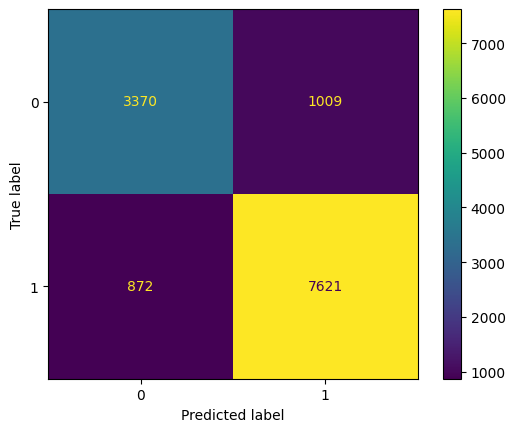

In [278]:
matriz = confusion_matrix(target_test, y_pred)

# Mostrarla visualmente
disp = ConfusionMatrixDisplay(confusion_matrix=matriz)
disp.plot();

In [279]:
#1. Separación de variables predictoras y objetivo del set de datos de validación
predictors_validacion = df_val.drop(columns=['respuesta'])
target_validacion = df_val["respuesta"]